In [179]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [180]:
# Reading the UNSW NB15 Dataset from the csv file
df = pd.read_csv('D:/drive/Home/Semester VII/dev/nsc/NID/UNSW_NB15.csv')

In [ ]:
# Data at a glance

df.info()
df.describe()
df.head()

In [183]:
# Data Cleaning

# check for duplicates 
df.duplicated().any()

False

In [184]:
# check for null values
df.isna().any()

id                   False
dur                  False
proto                False
service              False
state                False
spkts                False
dpkts                False
sbytes               False
dbytes               False
rate                 False
sttl                 False
dttl                 False
sload                False
dload                False
sloss                False
dloss                False
sinpkt               False
dinpkt               False
sjit                 False
djit                 False
swin                 False
stcpb                False
dtcpb                False
dwin                 False
tcprtt               False
synack               False
ackdat               False
smean                False
dmean                False
trans_depth          False
response_body_len    False
ct_srv_src           False
ct_state_ttl         False
ct_dst_ltm           False
ct_src_dport_ltm     False
ct_dst_sport_ltm     False
ct_dst_src_ltm       False
i

In [185]:
# dropping attack category, id
# ID does not provide any meaningful information to the model
# Attack category basically tells if label is 0 or 1, hence skip to avoid model bias

df = df.drop(['attack_cat', 'id'], axis=1)

In [186]:
# service_feature = df['service']
# service_array = service_feature.to_numpy()
# service_array_2d = service_array.reshape(-1,1)
# service_array_2d
# df['service'] = encoder.fit_transform(service_array_2d)

# Using One Hot Encoding to convert categorical features into numeric data to work with Logistic Regression
# LR only works with numeric data

categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

#Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(df[categorical_columns])

# Create a DataFrame with the one-hot encoded columns
# We use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded dataframe with the original dataframe
df = pd.concat([df, one_hot_df], axis=1)

# Drop the original categorical columns
df = df.drop(categorical_columns, axis=1)

df.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ssl,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,0.121478,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.623129,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.681642,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.449454,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
# Tried removing low or negatively correlated features to improve accuracy but it decreased instead
"""
# feature selection using correlation

low_correlation_features = []
correlation_matrix = df.corr()

for x in range(len(df.columns)):
    correlation_coefficient = correlation_matrix.loc['label', df.columns[x]]

    if (correlation_coefficient < 0):
        low_correlation_features.append(df.columns[x])

# dropping low correlation features

for x in range(len(low_correlation_features)):
    df = df.drop(low_correlation_features[x], axis=1)

"""

In [187]:
# Storing output column label in variable 'y'
# Removing 'label' from our dataframe as well to use it to train our model

y = df['label']
df = df.drop('label', axis=1)

In [188]:
# spliting the dataset into training and testing datasets by 70/30 ratio
# Using the golden number 42 as seed for random state

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)

In [189]:
# Training the model

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8510541223884569

In [ ]:
# The score (accuracy) from our trained model is '0.85' which is decent enough as too high scores mean our model 
# is over-fitted on the test data

In [194]:
# Testing the model on test data
# pred stores the list of predictions made against the test dataset

pred = lr.predict(X_test)

In [195]:
# Using confusion matrix to evaluate the performance of our model

cm = confusion_matrix(y_test, pred)
print(cm)

[[10095  6677]
 [ 1158 34673]]


In [ ]:
# The confusion matrix results are okay but not that good
# The false-negative results are low which is good since flagging a bad actor good is dangerous
# The false-positive while not as dangerous as the previous one can still be a nuisance to the users
# as its amount is quite high. Lets try to lower it

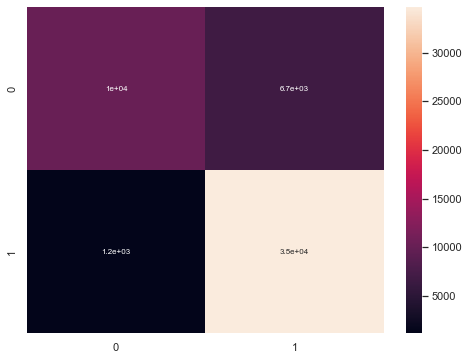

In [196]:
# Heat-map of Confusion Matrix

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, annot_kws={"size": 8})
plt.show()

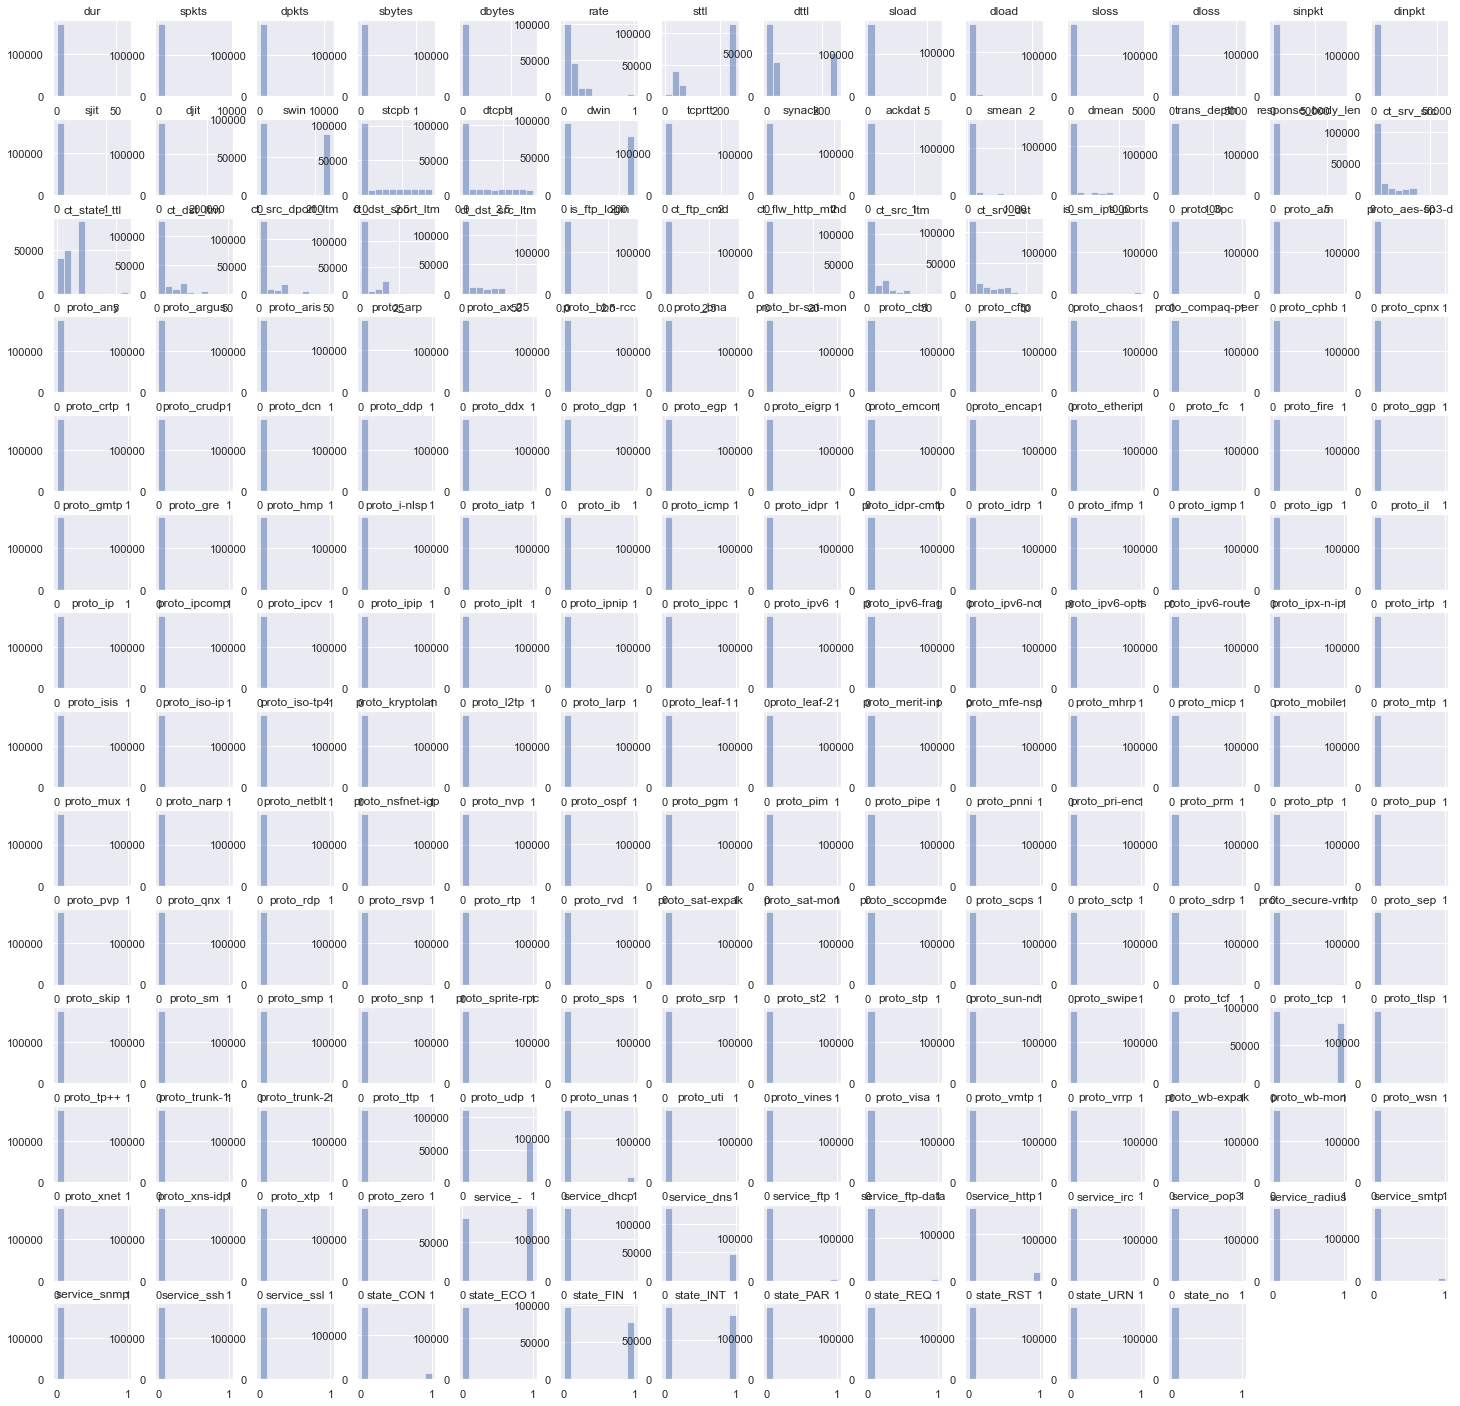

In [197]:
# Checking if features follow Gaussian or Non-Gaussian distributions

df.hist(alpha=0.5, figsize=(25, 25))
plt.show()

In [198]:
# As most features are binary or one-hot encoded and not following Gaussian Dist, MinMaxScaler is preffered to
# scale the values between 0 and 1 or -1 to 1 if negative values present
# Scaling the features generally makes gradient descent in logistic regression work with better accuracy

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Increasing the max iteration of the convergence algorithm used for LR in Scikit-Learn since value was
# getting stuck in a local minima despite the high accuracy

lr_scaled = LogisticRegression(solver='lbfgs', max_iter=2000)
lr_scaled.fit(X_train_scaled, y_train)
lr_scaled.score(X_test_scaled, y_test)

0.932608406364656

In [ ]:
# The score has greatly increased from 0.85 to 0.93

In [199]:
pred_scaled = lr_scaled.predict(X_test_scaled)
cm_scaled = confusion_matrix(y_test, pred_scaled)
print(cm_scaled)

[[13594  3178]
 [  367 35464]]


In [ ]:
# The number of false-negatives have gone down even further, making our model even better
# The false-positives have also gone down and improved the reliability of our model